# MovieRec

In this notebook, I'll build a deep learning model movie recommendations system on the MovieLens 20M dataset. [More info](https://github.com/korjusk/MovieRec)

In [1]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *

### Loading MovieLens 20m dataset
Download [link](http://files.grouplens.org/datasets/movielens/ml-20m.zip) and dataset [readme.](http://files.grouplens.org/datasets/movielens/ml-20m-README.html)  
  
MovieLens ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).  
IMDb ratings are made on a 10-star scale (1 stars - 10 stars).

In [13]:
path = 'data/'
ml20 = path + 'ml-20m/' 
!ls {ml20}

README.txt	   genome-tags.csv  movies.csv	 tags.csv
genome-scores.csv  links.csv	    ratings.csv


#### ratings.csv

In [89]:
ratings = pd.read_csv(ml20 + 'ratings.csv', encoding='latin-1')
print('Size:', len(ratings))
ratings.head(2)

Size: 20000263


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676


#### movies.csv

In [14]:
movies = pd.read_csv(ml20 + 'movies.csv', encoding='latin-1')
print('Size:', len(movies))
movies.head(2)

Size: 27278


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


#### links.csv

In [92]:
links = pd.read_csv(ml20 + 'links.csv', encoding='latin-1')
print('Size:', len(links))
links.head(2)

Size: 27278


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


### Loading my [IMDb ratings](https://www.imdb.com/user/ur15834927/ratings)

In [85]:
my_df = pd.read_csv(path + 'my_ratings.csv', encoding='latin-1')
my_df = my_df.sort_values('Date Rated').reset_index(drop=True)
print('Size:', len(my_df))

Size: 568


#### First and last movie I rated

In [86]:
my_df.iloc[[0, -1]]

,Const,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors
0,tt0111161,10,2007-08-12,The Shawshank Redemption,https://www.imdb.com/title/tt0111161/,movie,9.3,142.0,1994,Drama,2034334,1994-09-10,Frank Darabont
567,tt2397535,10,2015-11-28,Predestination,https://www.imdb.com/title/tt2397535/,movie,7.5,97.0,2014,"Drama, Mystery, Sci-Fi, Thriller",218780,2014-03-08,"Michael Spierig, Peter Spierig"


In [87]:
my_df.describe().round(decimals=1)

,Your Rating,IMDb Rating,Runtime (mins),Year,Num Votes
count,568.0,568.0,565.0,568.0,568.0
mean,8.0,7.6,109.4,2002.2,323541.1
std,1.9,0.9,37.7,10.3,332702.2
min,1.0,1.6,8.0,1942.0,13.0
25%,7.0,7.1,96.0,1999.8,84620.5
50%,8.0,7.7,108.0,2005.0,215472.0
75%,10.0,8.1,125.0,2008.0,454300.2
max,10.0,9.5,533.0,2014.0,2034334.0


### Format my ratings (my_df)

#### Add userId, rating, timestamp and imdbId to my_df

In [90]:
my_df['userId'] = max(ratings['userId']) + 1
my_df['rating'] = my_df['Your Rating'] / 2
my_df['timestamp'] = my_df['Date Rated'].astype('datetime64[ns]').astype('int64')//1000000000
my_df['imdbId'] = my_df['Const'].apply(lambda x: x[2:]).map(int)
my_df.iloc[[0, -1]]

,Const,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,userId,rating,timestamp,imdbId
0,tt0111161,10,2007-08-12,The Shawshank Redemption,https://www.imdb.com/title/tt0111161/,movie,9.3,142.0,1994,Drama,2034334,1994-09-10,Frank Darabont,138494,5.0,1186876800,111161
567,tt2397535,10,2015-11-28,Predestination,https://www.imdb.com/title/tt2397535/,movie,7.5,97.0,2014,"Drama, Mystery, Sci-Fi, Thriller",218780,2014-03-08,"Michael Spierig, Peter Spierig",138494,5.0,1448668800,2397535


#### Merge my_df with links and select only necessary columns

In [95]:
my_movies = my_df.merge(links, on='imdbId')
my_movies.to_pickle('data/my_movies_full_df.pkl')
my_movies = my_movies[['userId', 'movieId', 'rating', 'timestamp']]
my_movies.tail(2)

,userId,movieId,rating,timestamp
495,138494,77800,5.0,1448496000
496,138494,114935,5.0,1448668800


#### Concat my_df  with all ratings

In [11]:
all_df = pd.concat([ratings, my_movies], ignore_index=True)
all_df.tail(2)

,userId,movieId,rating,timestamp
20000758,138494,77800,5.0,1448496000
20000759,138494,114935,5.0,1448668800


In [12]:
all_df[all_df.timestamp == 1197417600]

,userId,movieId,rating,timestamp
20000286,138494,7346,4.0,1197417600
20000287,138494,912,3.5,1197417600


#### Merge titles

In [13]:
all_df['order'] = all_df.index
all_df = pd.merge(all_df, movies[['movieId', 'title']])
all_df = all_df.sort_values('order')
all_df = all_df.reset_index(drop=True)
all_df = all_df.drop(columns='order')

all_df.tail(2)

,userId,movieId,rating,timestamp,title
20000758,138494,77800,5.0,1448496000,Four Lions (2010)
20000759,138494,114935,5.0,1448668800,Predestination (2014)


In [14]:
print(f'Nr of missing values: {movies.isnull().values.sum()}')

Nr of missing values: 0


In [15]:
my_user_id = all_df[-1:]['userId'].values[0]
my_df = all_df[all_df.userId == my_user_id].copy()

### Select smaller dataset

To train faster I'm going to use 10x smaller dataset.  
Select most 1000 most rated movies by 4000 most active users.

In [16]:
g = all_df.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values
len(top_movies)

26744

In [17]:
top_movies_all_df = all_df[all_df['movieId'].isin(top_movies[:1300])]
len(top_movies_all_df)

14146866

In [18]:
g = top_movies_all_df.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False).index.values

print(len(top_users))
selected_users = np.append(top_users[:3999], my_user_id)

138490


In [19]:
top_user_movies_all_df = top_movies_all_df[top_movies_all_df['userId'].isin(selected_users)]
len(top_user_movies_all_df)

2391426

In [20]:
g = top_user_movies_all_df.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values
len(top_movies)

1300

In [21]:
selected_2m = top_user_movies_all_df[top_user_movies_all_df['movieId'].isin(top_movies[:1000])]

#selected_2m.to_pickle('data/selected_2m.pkl')
len(selected_2m)

2102290

### Split train and test data

In [16]:
good_idx = my_df[my_df.rating > 4].index.values
normal_idx = my_df[(my_df.rating <= 4) & (my_df.rating > 2)].index.values
bad_idx = my_df[my_df.rating <= 2].index.values

from random import shuffle
shuffle(good_idx)
shuffle(normal_idx)
shuffle(bad_idx)

test_idx = np.append(good_idx[:45], normal_idx[:50])
test_idx = np.append(test_idx, bad_idx[:5])

shuffle(test_idx)

test_df = all_df.iloc[test_idx]
train_df = all_df.drop(all_df.index[test_df.index])

test_df.reset_index(drop=True, inplace=True)
test_df.to_pickle('data/test_df.pkl')
train_df.to_pickle('data/train_df.pkl')

### Plot ratings

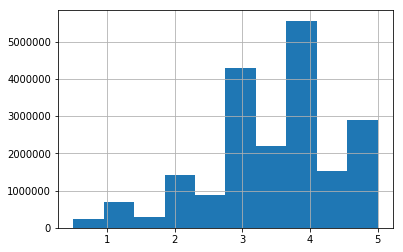

In [17]:
ratings.rating.hist()

#### x.5 ratings are used less frequently. Round them up and plot them with my ratings.

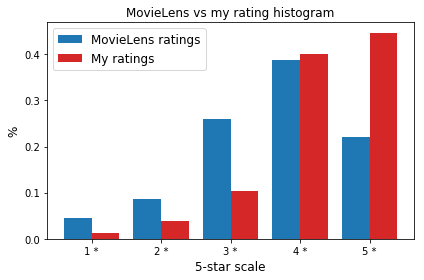

In [18]:
index = 5
bar_width = 0.4
font_size = 12

bar_data = (ratings.rating + 0.5).astype(int).value_counts(normalize=True)
x = bar_data.index.values - bar_width / 2

my_bar_data = (my_df.rating + 0.5).astype(int).value_counts(normalize=True)
my_x = my_bar_data.index.values + bar_width / 2

fig, ax = plt.subplots()

rects1 = ax.bar(x, bar_data, bar_width, color='tab:blue', label='MovieLens ratings')
rects2 = ax.bar(my_x, my_bar_data, bar_width, color='tab:red', label='My ratings')

ax.legend(fontsize=12)
ax.set_ylabel('%', fontsize=font_size)
ax.set_xlabel('5-star scale', fontsize=font_size)
ax.set_xticklabels([f'{x} *' for x in range(6)])
plt.title('MovieLens vs my rating histogram', fontsize=font_size)
fig.tight_layout()

plt.savefig('images/plt_rating_bar.png')
plt.show()

### Most voted movies

In [19]:
ratings_grouped = ratings.groupby('movieId')
idx = pd.Index(movies['movieId']).get_indexer(ratings_grouped.count().index.values)
top_df = movies.iloc[idx].copy()
top_df['nrOfVotes'] = ratings_grouped.count().userId.values
top_df['meanRating'] = ratings_grouped.mean().rating.values
top_df['myRating'] = top_df.movieId.apply(lambda x: np.NaN if my_df[my_df.movieId == x].empty else my_df[my_df.movieId == x].rating.values[0])
top_df = top_df.sort_values('nrOfVotes', ascending=False).reset_index(drop=True)

top_df.head()

,movieId,title,genres,nrOfVotes,meanRating,myRating
0,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,67310,4.174231,4.0
1,356,Forrest Gump (1994),Comedy|Drama|Romance|War,66172,4.029000,5.0
2,318,"Shawshank Redemption, The (1994)",Crime|Drama,63366,4.446990,5.0
3,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,63299,4.177057,3.5
4,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,59715,3.664741,NaN


In [20]:
print(f'I have seen {top_df[:500].myRating.notnull().values.sum()} out of top 500')

I have seen 132 out of top 500


#### Rare Movies
The least often rated movies that I've rated

In [21]:
top_df[top_df.myRating.notnull()].sort_values('nrOfVotes').head(2)

,movieId,title,genres,nrOfVotes,meanRating,myRating
22447,97781,Rolling (2007),Drama,2,3.0,5.0
21714,121103,Justin Bieber: Never Say Never (2011),Documentary,2,1.5,0.5


#### Unusual Likes
The movies where my rating is higher than average rating

In [22]:
top_df[top_df.myRating > 4].sort_values('meanRating').head(2)

,movieId,title,genres,nrOfVotes,meanRating,myRating
4105,69436,Year One (2009),Adventure|Comedy,605,2.532231,5.0
1938,63992,Twilight (2008),Drama|Fantasy|Romance|Thriller,2156,2.746521,5.0


#### Unusual Dislikes
The movies where my rating is lower than average rating

In [23]:
top_df[top_df.myRating <= 2].sort_values('meanRating', ascending=False).head(2)

,movieId,title,genres,nrOfVotes,meanRating,myRating
1193,1237,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",Drama,4142,4.102849,2.0
443,55820,No Country for Old Men (2007),Crime|Drama,10248,3.994389,1.0


#### Popularity of my rated movies

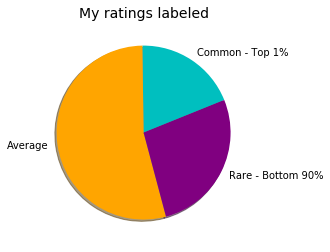

In [24]:
top1 = top_df[:round(len(top_df) * 0.01)]
my_top1_len = len(top1[top1.myRating.notnull()])

bottom90 = top_df[round(len(top_df) * 0.1):]
my_bottom90_len = len(bottom90[bottom90.myRating.notnull()])

my_average_len = 497 - my_top1_len - my_bottom90_len


labels = 'Common - Top 1%', 'Average', 'Rare - Bottom 90%'
fracs = [my_top1_len, my_average_len, my_bottom90_len]
colors = ['c', 'orange', 'purple']

plt.title('My ratings labeled', fontsize=14)
plt.pie(fracs, labels=labels, shadow=True, colors=colors, startangle=22)

plt.savefig('images/plt_popularity_pie.png')
plt.show()

The bottom 90% of movies in the dataset in terms of number of ratings are 'rare', while the top 1% are 'common'

### Movie genres
One Hot Encode genres

In [25]:
top_ohe = top_df[:500].copy().drop(columns=['nrOfVotes', 'meanRating', 'myRating'])
my_ohe = movies[movies.movieId.isin(my_df.movieId.values)].copy()

for i in top_ohe.index:
    raw = top_ohe.loc[i, 'genres']
    multy = raw.split('|')
    for w in multy:
        top_ohe.loc[i, w] = True

for i in my_ohe.index:
    # Set ratings
    movie_id = my_ohe.loc[i, 'movieId']
    rating = my_df[(my_df['movieId'] == movie_id) & (my_df['userId'] == my_user_id)]
    my_ohe.loc[i, 'rating'] = rating['rating'].values[0]
    
    raw = my_ohe.loc[i, 'genres']
    multy = raw.split('|')
    for w in multy:
        my_ohe.loc[i, w] = True


top_ohe.fillna(False, inplace=True)
my_ohe.fillna(False, inplace=True)

my_ohe.head(2)

,movieId,title,genres,rating,Adventure,Animation,Children,Comedy,Fantasy,Action,...,Romance,Mystery,War,Sci-Fi,Film-Noir,Musical,IMAX,Western,Horror,Documentary
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.5,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
5,6,Heat (1995),Action|Crime|Thriller,4.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


#### Find most frequent genres

In [26]:
genres = list(top_ohe.columns[3:])
genres = [(my_ohe[my_ohe[g]].rating.mean(), g) for g in genres]
genres.sort()
n_groups = len(genres)

top_count = [sum(top_ohe[g[1]]) for g in genres]

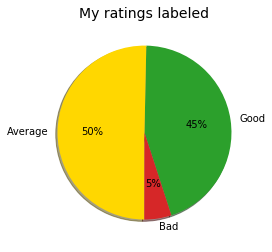

In [27]:
good = my_ohe[my_ohe['rating'] > 4]
normal = my_ohe[(my_ohe['rating'] <= 4) & (my_ohe['rating'] > 2)]
bad = my_ohe[my_ohe['rating'] <= 2]

good_pct = len(good) * 100 / len(my_df)
normal_pct = len(normal) * 100 / len(my_df)
bad_pct = len(bad) * 100 / len(my_df)

labels = 'Good', 'Average', 'Bad'
fracs = [good_pct, normal_pct, bad_pct]
colors = ['tab:green', 'gold', 'tab:red']

plt.title('My ratings labeled', fontsize=14)
plt.pie(fracs, labels=labels, autopct='%.0f%%', shadow=True, colors=colors, startangle=288)

plt.savefig('images/plt_rating_pie.png')
plt.show()

### Plot genre frequencies

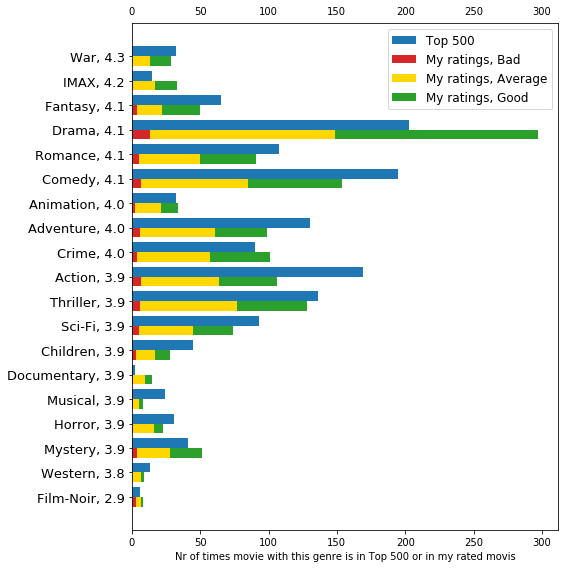

In [28]:
my_count_good = [sum(good[g[1]]) for g in genres]
my_count_normal = [sum(normal[g[1]]) for g in genres]
my_count_bad = [sum(bad[g[1]]) for g in genres]
my_count_not_good = [my_count_normal[i] + my_count_bad[i] for i in range(n_groups)]

fig, ax = plt.subplots(figsize=(8, 8))

index = np.arange(n_groups)
bar_width = 0.4

r0 = ax.barh(index + bar_width / 2, top_count, bar_width, color='tab:blue', label='Top 500')
r1 = ax.barh(index - bar_width / 2, my_count_bad, bar_width, color='tab:red', label='My ratings, Bad')
r2 = ax.barh(index - bar_width / 2, my_count_normal, bar_width, left=my_count_bad, color='gold', label='My ratings, Average')
r3 = ax.barh(index - bar_width / 2, my_count_good, bar_width, left=my_count_not_good, color='tab:green', label='My ratings, Good')

ax.set_xlabel('Nr of times movie with this genre is in Top 500 or in my rated movis')
ax.set_yticks(np.arange(n_groups))
ax.set_yticklabels([f'{g[1]}, {round(g[0], 1)}' for g in genres], fontsize=13)
ax.tick_params(labeltop=True, labelright=False)
ax.legend(fontsize=12)
fig.tight_layout()

plt.savefig('images/plt_genre_barh.png')
plt.show()

### Plot movie age
movie_age = 0 means that the movie release year is same as year rated timestamp

In [29]:
my_df.loc[:,'year'] = my_df.title.str[-5:-1]
date_rated = (my_df['timestamp']*1000000000).astype('datetime64[ns]')
year_rated = date_rated.astype('str').str[:4].astype(int)
my_df.loc[:, 'movie_age'] = year_rated - my_df.year.astype(int)

my_df.head(2)

,userId,movieId,rating,timestamp,title,year,movie_age
20000263,138494,318,5.0,1186876800,"Shawshank Redemption, The (1994)",1994,13
20000264,138494,58554,5.0,1187740800,"Class, The (Klass) (2007)",2007,0


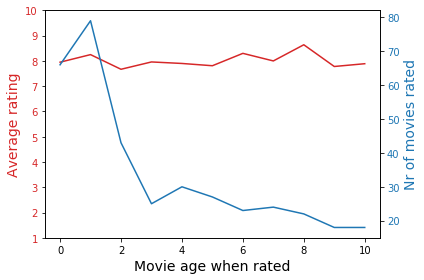

In [30]:
# Data for plotting
range_year = range(11)
rating_year = [round(my_df[my_df.movie_age == i].rating.mean() * 2, 2) for i in range_year]
views_year = [my_df[my_df.movie_age == i].rating.count() for i in range_year]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Movie age when rated', fontsize=14)
ax1.set_ylabel('Average rating', color=color, fontsize=14)
ax1.plot(range_year, rating_year, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks(np.arange(1, 11))

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Nr of movies rated', color=color, fontsize=14)  
ax2.plot(range_year, views_year, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

plt.savefig('images/plt_age_plot.png')
plt.show()

&nbsp;
# Collaborative filtering
&nbsp;

In [1]:
from fastai import *
from fastai.collab import *
from fastai.collab import CollabLearner
from fastai.tabular import *

Dot model for collaborative filtering

In [2]:
class EmbeddingDotBias(nn.Module):
    def __init__(self, n_factors:int, n_users:int, n_items:int, y_range:Tuple[float,float]):
        super().__init__()
        self.y_range = y_range
        (self.u_weight, self.i_weight, self.u_bias, self.i_bias) = [embedding(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)]]

    def forward(self, users:LongTensor, items:LongTensor) -> Tensor:
        dot = self.u_weight(users) * self.i_weight(items)
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        return torch.sigmoid(res) * (self.y_range[1]-self.y_range[0]) + self.y_range[0]

In [3]:
# Load DataFrames
selected_2m = pd.read_pickle('data/selected_2m.pkl')

In [4]:
data = CollabDataBunch.from_df(selected_2m, seed=1, pct_val=0.1)
data.show_batch(2)

userId,movieId,target
132331,4886,3.5
63858,3704,3.5


In [5]:
u,m = data.classes.values()
n_factors=30
y_range = (0.0, 5.5)
model = EmbeddingDotBias(n_factors, len(u), len(m), y_range=y_range)
wd=0.01
learn = CollabLearner(data, model, wd=wd)

In [6]:
learn.fit_one_cycle(2, 5e-3, wd=wd)

epoch,train_loss,valid_loss
1,0.600761,0.616277
2,0.513325,0.529996


In [ ]:
#learn.save('learn_100k_5_')

In [7]:
# learn_dataset_epoch_lr_wd_loss
learn = learn.load('learn_100k_5_0002_01_0.84')

### Interpretation

In [7]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(4001, 30)
  (i_weight): Embedding(1001, 30)
  (u_bias): Embedding(4001, 1)
  (i_bias): Embedding(1001, 1)
)

In [8]:
u, m = data.train_ds.x.classes.values()
m = m[1:]

In [9]:
my_user_id = [str(selected_2m.userId.max())]
top_movies_bias = learn.bias(m, is_item=True)
top_movies_weight = learn.weight(m, is_item=True)
my_user_bias = learn.bias(my_user_id, is_item=False)
my_user_weight = learn.weight(my_user_id, is_item=False)

print(top_movies_bias.shape, top_movies_weight.shape, my_user_bias.shape, my_user_weight.shape)

torch.Size([1000]) torch.Size([1000, 30]) torch.Size([]) torch.Size([1, 30])


In [10]:
dot = top_movies_weight * my_user_weight
res = dot.sum(1) + my_user_bias.squeeze() + top_movies_bias.squeeze()
sig_res = torch.sigmoid(res) * (y_range[1]-y_range[0]) + y_range[0]

print(sig_res.shape)

torch.Size([1000])


In [11]:
my_movies = pd.read_pickle('data/my_movies_full_df.pkl')
my_movies.head(1)

,Const,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,userId,rating,timestamp,imdbId,movieId,tmdbId
0,tt0111161,10,2007-08-12,The Shawshank Redemption,https://www.imdb.com/title/tt0111161/,movie,9.3,142.0,1994,Drama,2034334,1994-09-10,Frank Darabont,138494,5.0,1186876800,111161,318,278.0


In [21]:
movies[movies.movieId == int(12)]['title'].values[0]

'Dracula: Dead and Loving It (1995)'

In [23]:
movie_rec = []
for mm, rr in zip(m, sig_res):
    
    if not my_movies[my_movies.movieId == int(mm)].empty:
        movie_rec.append((round(rr.item() * 2), my_movies[my_movies.movieId == int(mm)]['Your Rating'].values[0], movies[movies.movieId == int(mm)]['title'].values[0]))


movie_rec = sorted(movie_rec, reverse=True)
movie_rec[:10]

[(10, 10, 'Shawshank Redemption, The (1994)'),
 (10, 10, 'Life Is Beautiful (La Vita Ã¨ bella) (1997)'),
 (10, 10, 'Forrest Gump (1994)'),
 (10, 10, 'Fight Club (1999)'),
 (10, 10, 'American History X (1998)'),
 (10, 10, 'American Beauty (1999)'),
 (10, 9, 'Usual Suspects, The (1995)'),
 (10, 9, 'Crash (2004)'),
 (10, 9, "Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)"),
 (9, 10, 'Vanilla Sky (2001)')]

#### Movie mean rating

In [ ]:
means = all_df.groupby('title')['rating'].mean().round(2)
means.head()

#### Movie Bias

In [ ]:
movie_bias = learn.bias(top_movies, is_item=True)

In [ ]:
stats = [(i, means[i], np.round(e.item(), decimals=2)) for i, e in zip(top_movies, movie_bias)]
print('title, mean ratings, bias')
stats[:5]